# Section 13.2 - Backpropagation

What makes these better/different than Hebbian models?

1. Multiple layers -- typically 3
2. Nonlinear layers
    - this will get implemented by applying a logistic function to get each layer's activation values
3. learning rule is not driven by the correct output, but by the _error_ in the model's output (ie, the discrepancy between the model's output and the correct output)
    - this will get implemented by having a "delta" matrix of error values for each layer that gets minimized during the learning process

## Weights and biases

Before applying all these things, we need a clear understanding of **the difference between a _weight_ and a _bias_**.

Movement from one layer to the next is an equation. The simplest way to consider it would be a linear equation. Indeed, with the weights and bias, it _is_ just a linear equation

$$ \hat{y} = wx + b $$

where $x$ is the input neuron, $w$ is the weight of the neuron, and then $b$ is the bias of that neuron. This is all to predict the activation of the output neuron, $\hat{y}$.

**It looks the same in matrix form**, but we use capital letters to indicate matrices, and use a dot product rather than simple multiplication.

$$ \hat{Y} = W \bullet X + B $$

where now $X$ is the activation of all input neurons, $W$ is the weight matrix that contains all weights from each neuron of $X$ to each neuron of $Y$, and $B$ is a vector that has a bias term _for each neuron_ in $Y$.

**To make it nonlinear**, we pick a function that modifies this linear prediction into something else.

$$ \hat{Y} = f( W \bullet X + B ) $$

## Backpropagation -- updating errors in reverse

We want to know how each layer's weights are affecting the overall error in the network? Of course we want to minimize the error.

We calculate the current layer’s error, and pass the weighted error back to the previous layer, continuing the process until we arrive at our first hidden layer. Along the way we update the weights using the derivative of cost with respect to each weight.

We will walk through each step, but first set everything up for the entire loop sequence.

In [2]:
from __future__ import division

import numpy as np; np.set_printoptions(precision=2)
import pandas as pd
from scipy.special import expit

import matplotlib.pyplot as plt; plt.ion()

## Variable setup

In [3]:
n_sweeps = 6000 # num of iterations

eta   = 0.1 # learning rate
alpha = 0.9 # momentum parameter

n_sets = 5
single_set_labels = ['reg1','reg2','reg3','reg4','irreg1']

# build the input pattern stims
n_stem = 10
n_other = 20
n_input_units = n_stem + n_other

index=pd.MultiIndex.from_product(
    [range(n_sets), single_set_labels],
    names=['set','word_type'])

columns = np.concatenate([
    np.repeat('stem',n_stem),
    np.repeat('nonstem',n_other)])

n_hidden_units = 15
n_output_units = 50

# stim parameters
# X = inputs, Y = outputs
X = pd.DataFrame(index=index,columns=columns)
Y = pd.DataFrame(index=index,columns=range(n_output_units))


'''
Build the stims
'''

for stimset in index.get_level_values('set').unique():

    stem   = np.random.randint(2,size=n_stem)
    reg_output = np.random.randint(2,size=n_output_units)

    # make the regular patterns
    for word_indx in single_set_labels:

        # each stim gets its own non-stem portion
        nonstem = np.random.randint(2,size=n_other)
        in_pattern = np.append(stem,nonstem)

        if 'irreg' in word_indx:
            # make a random output
            out_pattern = np.random.randint(2,size=n_output_units)
        else:
            out_pattern = reg_output.copy()

        X.loc[stimset,word_indx]  = in_pattern
        Y.loc[stimset,word_indx] = out_pattern

In [4]:
print 'INPUT PATTERNS'
X.head(10)

INPUT PATTERNS


stem  stem  stem  stem  stem  stem  stem  stem  stem  stem  \
set word_type                                                               
0   reg1          0     1     0     0     0     1     0     1     0     0   
    reg2          0     1     0     0     0     1     0     1     0     0   
    reg3          0     1     0     0     0     1     0     1     0     0   
    reg4          0     1     0     0     0     1     0     1     0     0   
    irreg1        0     1     0     0     0     1     0     1     0     0   
1   reg1          0     0     0     0     1     1     0     0     0     0   
    reg2          0     0     0     0     1     1     0     0     0     0   
    reg3          0     0     0     0     1     1     0     0     0     0   
    reg4          0     0     0     0     1     1     0     0     0     0   
    irreg1        0     0     0     0     1     1     0     0     0     0   

                ...     nonstem  nonstem  nonstem  nonstem  nonstem  nonstem  \
set word_type   ...                                                            
0   reg1        ...           0        0        1        0        1        1   
    reg2        ...           0        0        1        1        1        1   
    reg3        ...           0        1        0        0        0        0   
    reg4        ...           1        0        0        1        0        0   
    irreg1      ...           1        1        0        1        1        1   
1   reg1        ...           0        0        1        0        1        0   
    reg2        ...           1        1        1        1        1        1   
    reg3        ...           0        0        1        1        1        0   
    reg4        ...           1        1        0        0        0        0   
    irreg1      ...           1        0        1        1        1        0   

               nonstem  nonstem  nonstem  nonstem  
set word_type                                      
0   reg1             0        1        0        1  
    reg2             1        1        0        1  
    reg3             1        1        1        0  
    reg4             0        0        0        1  
    irreg1           1        1        0        0  
1   reg1             1        0        0        0  
    reg2             0        1        1        1  
    reg3             0        0        1        0  
    reg4             1        0        1        0  
    irreg1           0        0        1        1  

[10 rows x 30 columns]

In [5]:
print 'OUTPUT PATTERNS'
Y.head()

OUTPUT PATTERNS


0   1   2   3   4   5   6   7   8   9  ...  40  41  42  43  44  \
set word_type                                         ...                       
0   reg1        1   0   0   1   0   0   1   1   0   0 ...   0   1   1   1   0   
    reg2        1   0   0   1   0   0   1   1   0   0 ...   0   1   1   1   0   
    reg3        1   0   0   1   0   0   1   1   0   0 ...   0   1   1   1   0   
    reg4        1   0   0   1   0   0   1   1   0   0 ...   0   1   1   1   0   
    irreg1      1   0   0   0   0   0   1   1   1   0 ...   1   0   1   0   1   

               45  46  47  48  49  
set word_type                      
0   reg1        1   0   1   1   0  
    reg2        1   0   1   1   0  
    reg3        1   0   1   1   0  
    reg4        1   0   1   1   0  
    irreg1      0   0   1   0   0  

[5 rows x 50 columns]

### Initialize the empty weight, bias, and delta/error matrices

In [14]:
# this one projects the input units to the hidden units
W_xh = np.random.normal(size=[n_hidden_units,n_input_units]) * .01

# this one projects the hiddens units to the output units
W_hy = np.random.normal(size=[n_output_units,n_hidden_units]) * .01

# bias *vector* of the hidden layer
B_h = np.repeat(.01, n_hidden_units)
# bias *vector* of the output layer
B_y = np.repeat(.01, n_output_units)

## delta matrices
'''
These are the backpropagation part!
These will hold the delta values (error) to be passed
    back to the hidden units (so they know how they "did").
    The network will try to minimize these!!!
'''
delta_W_xh = np.zeros_like(W_xh)
delta_W_hy = np.zeros_like(W_hy)

### Before we do the whole loop thing, we will walk through just one loop.

#### Get the input and output patterns

In [15]:
# pick the first loop iteration
sweep = 0

# pick a random pattern to train on
randi = np.random.randint(X.shape[0])

# cue (input pattern)
x = X.iloc[randi,:].values
# target (output pattern)
y = Y.iloc[randi,:].values

print 'INPUT LAYER ACTIVATION'
print x

print 'OUTPUT LAYER ACTIVATION'
print y

INPUT LAYER ACTIVATION
[0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1]
OUTPUT LAYER ACTIVATION
[0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 0]


#### Move from the input layer to the hidden layer

In [16]:
# START calculating to get to hidden layer
# (linear part)
Z_xh = np.dot(W_xh,x) + B_h
# apply logistic function to get hidden layer activations
# (nonlinear part)
h = expit(Z_xh) # hidden layer activation

print 'HIDDEN LAYER ACTIVATION'
print h

HIDDEN LAYER ACTIVATION
[ 0.51  0.51  0.51  0.51  0.5   0.51  0.49  0.51  0.51  0.5   0.5   0.51
  0.52  0.5   0.5 ]


#### Move from the hidden layer to the output layer

In [17]:
## same deal to get to output layer

Z_hy = np.dot(W_hy,h) + B_y
# NOTE hat thing--this is a prediction
y_hat = expit(Z_hy) # output layer activation

print 'PREDICTED OUTPUT LAYER ACTIVATION'
print y_hat

PREDICTED OUTPUT LAYER ACTIVATION
[ 0.5   0.5   0.5   0.5   0.5   0.5   0.51  0.5   0.51  0.5   0.5   0.5
  0.51  0.51  0.5   0.5   0.5   0.51  0.51  0.51  0.51  0.5   0.5   0.5
  0.5   0.5   0.49  0.5   0.51  0.51  0.5   0.5   0.51  0.5   0.49  0.5
  0.5   0.51  0.5   0.51  0.5   0.51  0.51  0.5   0.51  0.5   0.5   0.5
  0.5   0.51]


#### Backpropagation part

We have the predicted output layer now. Is it right? We now evaluate how well the network did, and update the entire network (weights and biases) accordingly.

#### Find the error from hidden layer to output layer

In [18]:
# get the error of the output layer
# the first half of this equation is the difference between target and predicted output
# the second half of this equation is the derivative of the logistic function
delta_output = (y-y_hat) * y_hat*(1-y_hat)

# incorporate the weights between the hidden and output layers
delta_W_hy = alpha*delta_W_hy + eta*np.outer(delta_output,h)

print 'SIZE OF ERROR MATRIX BETWEEN HIDDEN AND OUTPUT LAYERS'
print delta_W_hy.shape

SIZE OF ERROR MATRIX BETWEEN HIDDEN AND OUTPUT LAYERS
(50, 15)


#### Move back again to get error between input and hidden layer

In [19]:
## find the error in input-to-hidden weights
delta_hidden = np.dot(np.transpose(W_hy),delta_output) * h*(1-h)
delta_W_ih = alpha*delta_W_xh + eta*np.outer(delta_hidden,x)

#### Finally, update the weight and bias matrices accordingly

In [20]:
## update the weights and biases
W_hy += delta_W_hy
W_xh += delta_W_xh
B_y += eta * delta_output
B_h += eta * delta_hidden

## Run through all iterations (listing 13.6)

In [21]:
# reinitialize empty stuff
W_xh = np.random.normal(size=[n_hidden_units,n_input_units]) * .01
W_hy = np.random.normal(size=[n_output_units,n_hidden_units]) * .01
B_h = np.repeat(.01, n_hidden_units)
B_y = np.repeat(.01, n_output_units)
delta_W_xh = np.zeros_like(W_xh)
delta_W_hy = np.zeros_like(W_hy)

reg_errors = []
irreg_errors = []


for sweep in range(n_sweeps):
    '''
    - capital X means input matrix
    - lowercase x means input matrix VECTOR (one sample)
    '''

    # pick a random pattern to train

    randi = np.random.randint(X.shape[0])

    # cue (input pattern)
    x = X.iloc[randi,:].values
    # target (output pattern)
    y = Y.iloc[randi,:].values

    # START calculating to get to hidden layer
    # (linear part)
    Z_xh = np.dot(W_xh,x) + B_h
    # apply logistic function to get hidden layer activations
    # (nonlinear part)
    h = expit(Z_xh) # hidden layer activation


    ## same deal to get to output layer

    Z_hy = np.dot(W_hy,h) + B_y
    # NOTE hat thing--this is a prediction
    y_hat = expit(Z_hy) # output layer activation


    # apply PERFORMANCE EVALUATION
    rmsd = np.sqrt(np.mean((y-y_hat)**2))

    if 'irreg' in X.reset_index().iloc[randi,1]:
        irreg_errors.append(rmsd)
        reg_errors.append(np.nan)
    else:
        reg_errors.append(rmsd)
        irreg_errors.append(np.nan)


    ### BACKPROPAGATION PART
    ### note how it "moves backwards"

    ## find the error in hidden-to-output weights
    
    delta_output = (y-y_hat) * y_hat*(1-y_hat)
    delta_W_hy = alpha*delta_W_hy + eta*np.outer(delta_output,h)

    ## find the error in input-to-hidden weights
    delta_hidden = np.dot(np.transpose(W_hy),delta_output) * h*(1-h)
    delta_W_xh = alpha*delta_W_xh + eta*np.outer(delta_hidden,x)

    ## update the weights and biases
    W_hy += delta_W_hy
    W_xh += delta_W_xh
    B_y += eta * delta_output
    B_h += eta * delta_hidden

## Plot figure 13.9

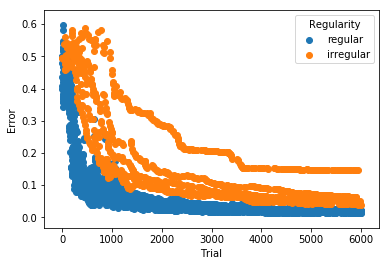

In [25]:
plt.scatter(range(n_sweeps), reg_errors, label='regular')
plt.scatter(range(n_sweeps), irreg_errors, label='irregular')

plt.xlabel('Trial')
plt.ylabel('Error')

plt.legend(title='Regularity');